In [1]:
import pandas as pd
import numpy as np
import torch
import os
import sys
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation as animation
import mpl_toolkits.axes_grid1
import matplotlib.widgets

%load_ext autoreload
%autoreload 2

from em_discrete.tasks.binary_linearVB import BinaryLinearVBTask
from em_discrete.utils.result_handling import parse_directory
from em_discrete.models.rnn_model import RNNModel
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer, seed_everything

from emt_tools.utils import spectral_comparison
from emt_tools.models.linearModel import LinearModel

In [2]:
## Some customization for the notebook

# assert "EXPERIMENT_OUTPUT_DIR" in os.environ, "environment not set"

## use this if you have your own experiment output directory set
# EXPERIMENT_OUTPUT_DIR=os.environ["EXPERIMENT_OUTPUT_DIR"]

## else results are stored in the current directory
EXPERIMENT_OUTPUT_DIR="./"

EXPERIMENT_NAME = "rcopy_test"
EXPERIMENT_PATH = os.path.join(EXPERIMENT_OUTPUT_DIR, EXPERIMENT_NAME)

TASK_ID = (255, 0, 0)  # this is the task id for repeat copy. Dont change unless you know what you are doing - some alternate ones are below
# TASK_ID = (9241421688590303745, 262676, 189) # \mathcal{T}_2 in the paper 
# TASK_ID = (9241421688590303745, 0, 0) # \mathcal{T}_3
# TASK_ID = (9241421688590303745, 38637, 145) # \mathcal{T}_4
# we denote each task in the VB tasks by a three tuple representation
# 1st number in the tuple encodes the choice of dimensions - d dimensions chosen from s*d possibilities
# 2nd number denotes a permutation of the dimensions - d! possibilities
# 3rd number denotes the sign of the linear operator - +/- 2^d possibilities

SEED = 0
INPUT_DIM = 8
SEQ_LENGTH = 8
HIDDEN_DIM = 128
LEARNING_RATE = 1e-3
BATCH_SIZE = 64
GRADIENT_CLIP = 1.0
L2_PENALTY = 0.0
CURRICULUM_THRESHOLD = 0.96
MAX_EPOCHS = 10

if torch.cuda.is_available():
    ACCELERATOR = "gpu"
else:
    ACCELERATOR = "cpu"

## Train rcopy task

Pytorch-lightning is used to train the models and tasks already available. 
The training takes ~10 mins to complete. You can monitor progress using tensorboard.
You should find that the trianing accuracy approaches 1.0 (perfect accuracy).

Curriculum training is done so that the RNN converges. It may be necessary for complex tasks but if only running 
repeat copy, curriculuum trainin may not be necessary.

In [4]:
torch.manual_seed(SEED)
np.random.seed(SEED)
seed_everything(SEED)

model = RNNModel(INPUT_DIM, HIDDEN_DIM, INPUT_DIM, bias=False) # set bias False so that origin is a fixed point

lmodule = BinaryLinearVBTask(model, 
                              seed=SEED, # for reproducibility
                              learning_rate=LEARNING_RATE,
                              batch_size=BATCH_SIZE,
                              input_dim=INPUT_DIM,
                              seq_length=SEQ_LENGTH,
                              model_type='rnn',
                              hidden_dim=HIDDEN_DIM,
                              task_id=TASK_ID,
                              curriculum=True,  # set this so that curriculuum training is done
                              curriculum_threshold=CURRICULUM_THRESHOLD,
                              l2_penalty=L2_PENALTY)

logger = TensorBoardLogger(save_dir=os.path.join(EXPERIMENT_OUTPUT_DIR, EXPERIMENT_NAME),
                           log_graph=True, version=0, name="rcopy")

trainer = Trainer(logger=logger, gradient_clip_val=GRADIENT_CLIP,
                  max_epochs=MAX_EPOCHS, deterministic=True, accelerator=ACCELERATOR,
                  num_sanity_val_steps=0, default_root_dir=os.path.join(EXPERIMENT_OUTPUT_DIR, 
                                                                        EXPERIMENT_NAME))

trainer.fit(lmodule)

[rank: 0] Seed set to 0
/work/pi_erietman_umass_edu/arjun/envs/waveRNN/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /work/pi_erietman_umass_edu/arjun/envs/waveRNN/lib/p ...
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/work/pi_erietman_umass_edu/arjun/envs/waveRNN/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params | Mode 
------------------------------

-------------------------Initializing train dataloader


/work/pi_erietman_umass_edu/arjun/envs/waveRNN/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]==================Logging computational graph
Epoch 0: |          | 508/? [00:10<00:00, 47.90it/s, v_num=0, training loss=0.269, accuracy=0.951]Curriculum difficulty increased to: 2/5
Epoch 0: |          | 583/? [00:11<00:00, 49.56it/s, v_num=0, training loss=0.243, accuracy=0.955]Curriculum difficulty increased to: 3/5
Epoch 0: |          | 644/? [00:12<00:00, 50.44it/s, v_num=0, training loss=0.262, accuracy=0.947]Curriculum difficulty increased to: 4/5
Epoch 0: |          | 695/? [00:13<00:00, 51.48it/s, v_num=0, training loss=0.263, accuracy=0.950]Curriculum difficulty increased to: 5/5
Epoch 9: |          | 2000/? [00:34<00:00, 57.79it/s, v_num=0, training loss=0.0122, accuracy=1.000] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: |          | 2000/? [00:34<00:00, 57.68it/s, v_num=0, training loss=0.0122, accuracy=1.000]


# Mechanistic Interpretations of the learned RNN

We will now apply the episodic memory theory described in [Episodic Memory Theory of Recurrent Neural Networks: Insights into Long-Term Information Storage and Manipulation](https://openreview.net/pdf?id=PYoEjBFAIM) to interpret the learned weights of the RNN.

## Step 1 - Linearization

The first step for preparing the model for EMT is linearization. Our RNN is specially set up such that we dont have to spend much effort in this part. However, if dealing with more complex networks linearization has to be performed using the following steps (Outlined in the [Opening the Black Box: Low-dimensional dynamics in high-dimensional recurrent neural networks](https://barak.net.technion.ac.il/files/2012/11/sussillo_barak-neco.pdf)) which is basically:

1. find fixed points of the system.
2. compute the jacobian at these fixed points and linearize the system around them.
3. currently EMT works when readout weights do not have bias. So confirm that this is the case.

In the end, you will have a linear system. In our particular setup, the origin is a fixed point and the jacobian evaluated at the origin is the identity matrix (why? try and see), so our taylor series expansion looks like this

$$h(t) = \tanh(W_{hh} h(t-1)) = W_{hh} h(t-1) + O(h(t-1)^2)$$

In [9]:
# WARNING: depending on how many times the trianing was run, the 'v-1' can be different
# verify this prior to running
TEST_HORIZON = 200 # set this to higher than 100 to see model generalizing to timescales not observed during training

# load the saved model (only necessary if training is separate from testing)
model_path = os.path.join(EXPERIMENT_OUTPUT_DIR, EXPERIMENT_NAME, "rcopy", 
                        "version_0", "checkpoints", "epoch=9-step=20000.ckpt")

if ACCELERATOR == "gpu":
    device = "cuda"
else:
    devide = "cpu"

lmodel = BinaryLinearVBTask.load_from_checkpoint(model_path, map_location=torch.device(device))
lmodel.eval() # put the model in the eval mode

emt_linear_model = LinearModel(lmodel.input_dim, lmodel.model.hidden_dim) # linear model class for interpretations

# this line will parse your trained model into the emt-lmodel
emt_linear_model.parse_simple_rnn(lmodel.model)

#### Model Verification

you might want to verify that your model is working as expected and make sure it is actually doing the task it is trained to do. For this, we will sample one evolution trajectory from the model. 

Conveniently, the `RNN` model saves the history of hidden states to make it easier to access later for interpretations.

Accuracy: 0.999873046875


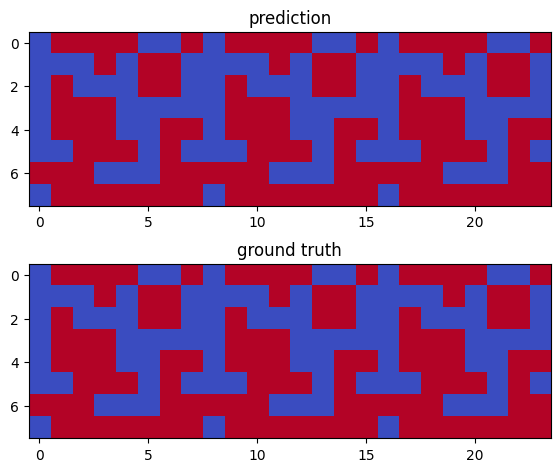

In [10]:
lmodel.test_dataset.set_horizon(TEST_HORIZON)
test_dataset = lmodel.test_dataset.__iter__()

# sample from the test set
sample = next(test_dataset)
x, y = sample
x = x.to(device)
y = y.to(device)

lmodel.model.initialize_hidden(batch_size=BATCH_SIZE, device=device) # initialize the hidden state of the RNN

y_hat = lmodel.model.forward(x) # propagate the inputs through the RNN

## These are some transformations so that the outup and targets
## are correctly shaped
y_hat = y_hat.reshape((-1, lmodel.model.input_dim))
y_hat = y_hat.reshape((-1, BATCH_SIZE, lmodel.model.input_dim))
y_hat = y_hat[lmodel.seq_length:, :, :]

y = y[lmodel.seq_length:, :, :]

# convert predictions
y_hat_predictions = y_hat.detach().clone()
y_hat_predictions[y_hat_predictions >= 0] = 1
y_hat_predictions[y_hat_predictions < 0] = -1
y_hat_predictions = y_hat_predictions.long()

y = y.cpu().detach().numpy()
y_hat_predictions = y_hat_predictions.cpu().detach().numpy()

# compute accuracy of prediction on the test sample
accuracy = (y_hat_predictions.astype(np.int_) == y.astype(np.int_)).astype(np.int_) 

print("Accuracy: {}".format(np.mean(accuracy)))  # accuracy may not be exactly 1 - not all RNNs perfectly generalize

# visualize predictions against ground truth
plt.subplot(211)
plt.imshow(y_hat_predictions[:24, 0, :].T, cmap="coolwarm")
plt.title("prediction")

plt.subplot(212)
plt.imshow(y[:24, 0, :].T, cmap="coolwarm")
plt.title("ground truth")

plt.tight_layout()
plt.show()

## Step 2 - Verify the variable binding model in EMT with experiments

It is easy to verify that the mechanistic description of variable binding is indeed the one our trained RNN learns. 
All we have to do is compare the spectrums and see that $\Phi$ and $W_{hh}$ have the same spectrum. 

They are expected to have the same spectrum since $\Phi$ and $W_{hh}$ differ only by a basis change 
(check EMT paper for more details).

In [11]:
## First we need to construct a theoretical version of Phi. Luckily, the data generating  
## class has a f_operator member encoding the composition function.

## construct phi theoretical
phi_theoretical = np.eye(lmodel.seq_length*lmodel.input_dim)
phi_theoretical = np.roll(phi_theoretical, lmodel.input_dim)

phi_theoretical[:, :lmodel.input_dim] = 0
phi_theoretical[-lmodel.input_dim:, :] = lmodel.test_dataset.f_operator.cpu().data.numpy().T

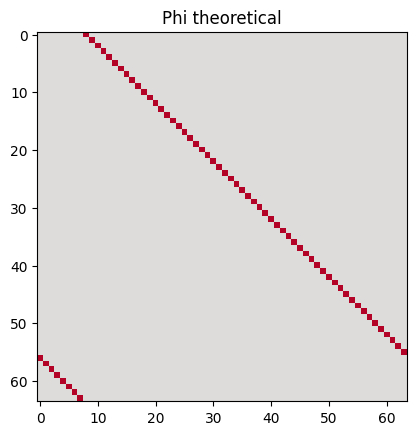

In [12]:
## visualize phi_theoretical and verify
plt.imshow(phi_theoretical, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Phi theoretical")
plt.show()

Now we actually compare the spectrums of the theoretical phi and the learned W_{hh}

First, we do a quantitative comparison of the spectrum. emt-tools.utils has a convenience function for this 
the way to interpret the value is:

Compared to $\Phi$, $W_{hh}$ spectrum for eigenvalues with mag(evals)>1-threshold
has an error of this many degrees (which should be small if $W_{hh}$ and $Phi$ are similar matrices)

In [13]:
print("spectral error (in degrees): {}".format(np.degrees(spectral_comparison(emt_linear_model.W_hh, phi_theoretical))))

(64,) (64,)
spectral error (in degrees): 0.027331276620361906


#### We can also verify this visually. 

In some cases, we will see the spectrum match exactly (both angle and magnitude of the eigenvalues) but this is 
not necessarily the case.

To understand this, we have to think about what the spectrum really means. According to spectral analysis in non-linear dynamical systems, a complex valued real number means that there are rotations (limit cycles) in the dynamical behavior of the system. Further, linearization says that if the eigenvalues have magnitude greater than 1, the dynamical behavior is expected to diverge to infinity.

But, if one were to analyze the dynamical behavior of tanh RNN models which is non-linear, the diverging behavior of the linear model meets the squashing behavior of the tanh non-linearity. The result is that instead of the trajectory diverging to infinity as suggested by linearization, the trajectory forms a *stable limit cycle*. This is the reason we dont care about the magnitude of the eigenvalue as long as it is closer to or greater than 1

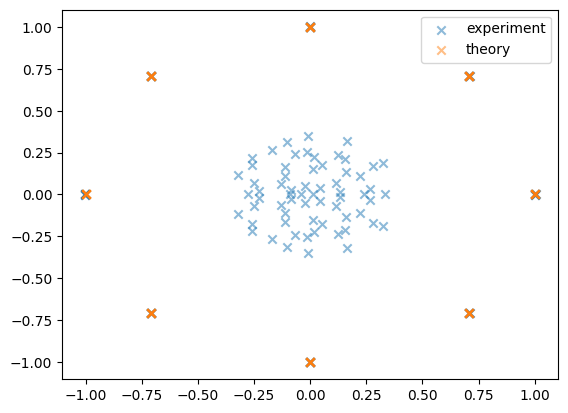

In [14]:
# I have a better visualization with illustrations in the paper
eig_vals, eig_vecs = np.linalg.eig(emt_linear_model.W_hh)
plt.scatter(eig_vals.real, eig_vals.imag, label="experiment", marker="x", alpha=0.5)

eig_vals, eig_vecs = np.linalg.eig(phi_theoretical)
plt.scatter(eig_vals.real, eig_vals.imag, label="theory", marker="x", alpha=0.5)

plt.legend()
plt.show()

## Step 3

It may not be interesting to just verify that the theoretical $\Phi$ is what is learned within $W_{hh}$, we may need to actually convert $W_{hh}$ so that we can interact with the underlying $\Phi$. Imagine this method to be similar to how you are opening the bonnet of a car to reveal all the juicy components inside. One can imagine that you can manipulate these components to either "fix" your car or "tune" the car to improve its behavior.

EMT tells that we just need to find the right basis so that we can convert $W_{hh}$ to the easily interpreted $\Phi$ matrix. We suggest one such privileged basis in the paper which grounds the basis in the output space of the RNN (the paper really grounds in the input space but I have lately found that output space works much better for general tasks more complicated than repeat copy). `emt-tools` has functions that let you do exactly this.

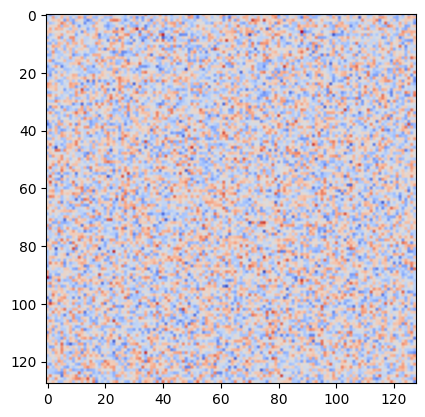

In [15]:
# prior to basis change, lets visualize what W_{hh} really looks like without changing basis

plt.imshow(emt_linear_model.W_hh, cmap="coolwarm")
plt.show()

In almost all cases, you will not find any discernible patterns here. This is because the $\Phi$ structure only emerges when the model learns in the standard basis. We can now change the basis of $W_{hh}$ with what is called the *variable memories* in the paper. 

In the visualization, the ground truth transition function of the linear tasks is shown below.

Matrix size: (128, 128)
Rank: 64


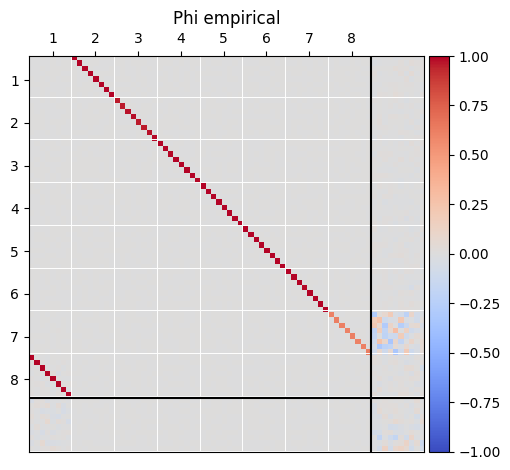

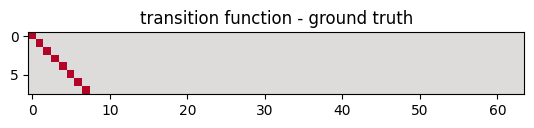

In [22]:
# compute the basis vectors for variable memories
# Psi is the bases, Psi_star is the basis dual (https://en.wikipedia.org/wiki/Dual_basis)
Psi, Psi_star = emt_linear_model.get_variable_basis(lmodel.seq_length, 
                                            lmodel.model.all_hidden.cpu().data.numpy()[:, 0, :].squeeze(),
                                            alpha=1, 
                                            f_operator=lmodel.train_dataset.f_operator.cpu().data.numpy().T,
                                            strength=1,
                                            threshold=0.99)

Phi_empirical = Psi_star @ emt_linear_model.W_hh @ Psi  # W_hh in the space of variable memories


## this might look like a lot but all it is doing is plotting Phi_empirical in a visually appealing manner
ax = plt.subplot()
im = ax.imshow(Phi_empirical.real, cmap="coolwarm", vmin=-1, vmax=1, alpha=1)

# create an Axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

for i in range(lmodel.input_dim):
    ax.axhline(y=((i+1)*lmodel.seq_length)-.9, color='w', linestyle='-', lw=0.7)

for j in range(lmodel.input_dim):
    ax.axvline(x=((j+1)*lmodel.seq_length)-.5, color='w', linestyle='-', lw=0.7)

ax.axhline(y=lmodel.input_dim*lmodel.seq_length-0.5, color='k', linestyle='-')
ax.axvline(x=lmodel.input_dim*lmodel.seq_length-0.5, color='k', linestyle='-')

ax.set_xticks(np.arange(lmodel.input_dim//2, lmodel.input_dim*lmodel.seq_length, lmodel.input_dim), range(1, lmodel.seq_length+1))
ax.set_yticks(np.arange(lmodel.input_dim//2, lmodel.input_dim*lmodel.seq_length, lmodel.input_dim), range(1, lmodel.seq_length+1))
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

ax.set_title("Phi empirical")
plt.tight_layout()
plt.show()

plt.imshow(lmodel.train_dataset.f_operator.T, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("transition function - ground truth")
plt.show()

One might ask, what else can we do with EMT. You can use the privileged basis that you constructed to even visualize where each *variable* is stored at all points in time.

**NOTE**: We can only *estimate* the basis rather than obtain them exactly. This is because the basis elements are not constrained to be orthogonal in which case the dual basis is a pseudoinverse which will have inherent estimation errors due to how inverse is computed. Nevertheless, the hope of the basis transformation is that in at-least the long-term behavior these minor errors will die down.

This effect can be noticed when you use the basis transformation to find the *variables* hidden in the hidden state.

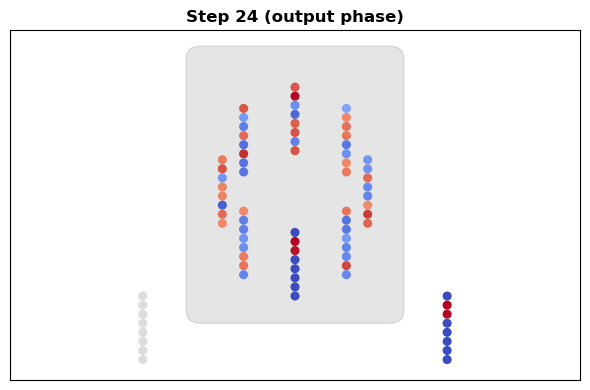

In [70]:
## First lets collect the input_history, output_history from our previous simulation
output_history = np.zeros((x.shape[0], lmodel.input_dim))
output_history[lmodel.seq_length:] = y_hat[:, 0, :].squeeze().cpu().data.numpy().copy()

input_history = x[:, 0, :].squeeze().cpu().data.numpy().copy()

emt_linear_model.plot_evolution_basis(input_history, # u_history
                                       lmodel.model.all_hidden[:3*lmodel.seq_length, 0, :].cpu().data.numpy(),  # h_history
                                       output_history,  # y_history
                                       Psi_star,  # Psi_star
                                       None,  # Phi (not required)
                                       lmodel.input_dim,  # task_dimension
                                       lmodel.seq_length,  # seq_length
                                       "animation.gif")

## Open Questions

Now that you have a sense of what EMT is capable of, you can think about:

- How can EMT be extended to handle more complex problems?
- How to build *interventions* like the mechanic that can tune and/or fix your model?
- How can EMT be extended to more complex architectures like transformers?
- What about simple feedforward architectures.
- How to explain classical mechanistic interpretability phenomenons like grokking, superposition using EMT.

More ambitious ones can be 

- How and Why does this particular variable binding mechanism emerge after applying simple backpropagation algorithm?
- I have found that even models whose matrices have less rank than what is required by EMT also generalizes. What exactly is happening there?

Lot of interesting questions yet to be explored.